## Imports

In [1]:
import numpy as np
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt

# from custom files
from dataset import CompCarsImageFolder, WrapperDataset
from models import ResNet, resnet_cfg
from models import train, validate
from utils import *

/home/michael/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


## Configuration

In [2]:
###### Set root to the image folder of CompCars dataset ######

#TODO: ADAPT TO YOUR FOLDER STRUCTURE
root = '../cars_data/data/image'

#############################################################

### Hyperparam configuration
params = {                  ## Training Params (taken from original resnet paper: https://arxiv.org/pdf/1512.03385)
    'epoch_num': 10,        # number of epochs
    'lr': 1e-1,             # (initial) Learning Rate
    'weight_decay': 1e-4,   # L2 Penalty
    'batch_size': 64,      # batch size
    'momentum': 0.9,
    
    'hierarchy': 0,         # Choose 0 for manufacturer classification, 1 for model classifciation
    'val_split': 0.2,        # Fraction of validation holdout
    
    'resnet': resnet_cfg['resnet18']  # Resnet model used
}

### Device
if torch.cuda.is_available():
    params["device"] = torch.device("cuda")   # option for NVIDIA GPUs
elif torch.backends.mps.is_available():
    params["device"] = torch.device("mps")    # option for Mac M-series chips (GPUs)
else:
    params["device"] = torch.device("cpu")    # default option if none of the above devices are available

print("Device: {}".format(params["device"]))

Device: cpu


# Data Pipeline

## Read total Dataset

In [3]:
# hierarchy=0 -> manufacturer classification; hierarchy=1 -> model classification
total_set = CompCarsImageFolder(root, hierarchy=params['hierarchy'])
print(total_set.classes)
print(len(total_set.classes))

['1', '10', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '11', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '12', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '13', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '14', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '15', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '16', '160', '161', '162', '163', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '9', '90', '91', '92', '93', '9

## Raw Data Visualization

Image shape: (908, 626)
Image shape: (800, 567)
Image shape: (800, 567)
Image shape: (908, 626)
Image shape: (800, 567)
Image shape: (800, 567)
Image shape: (800, 552)
Image shape: (800, 567)
Image shape: (908, 626)
Image shape: (908, 626)
Image shape: (908, 626)
Image shape: (800, 482)
Image shape: (908, 626)
Image shape: (908, 626)
Image shape: (908, 626)


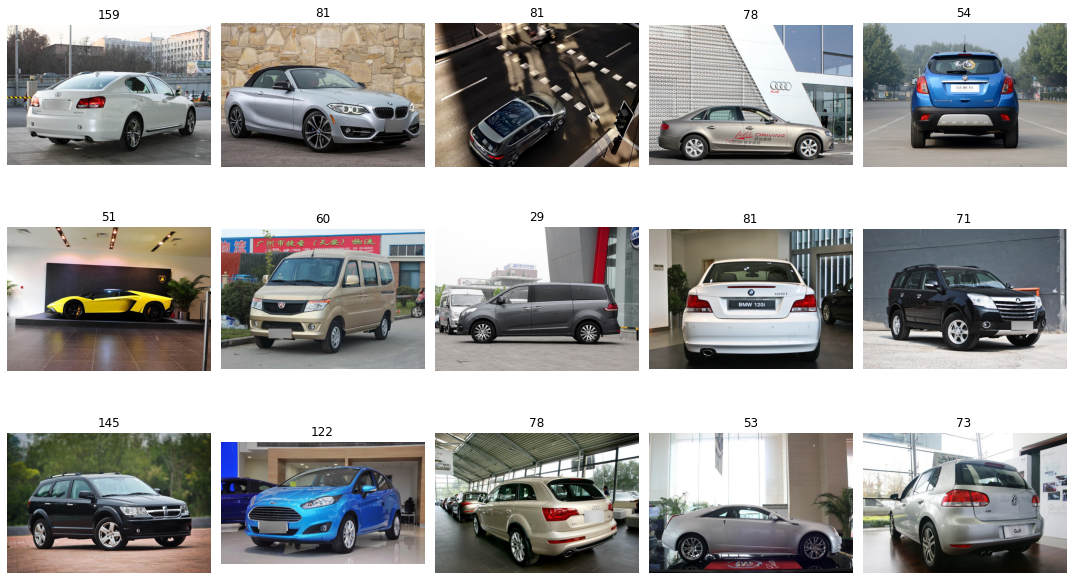

In [4]:
# Visualization of the dataset
label_dict = {y: x for x, y in total_set.class_to_idx.items()}

num_images_to_show = 15
data_idx = np.random.randint(0, high=len(total_set), size=num_images_to_show)
num_cols = 5
num_rows = num_images_to_show // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 3))
axes = axes.flatten()
for i in range(num_images_to_show):
    image, label = total_set[data_idx[i]]
    npimg = np.array(image)
    axes[i].imshow(npimg)
    axes[i].set_title(label_dict[label])
    axes[i].axis('off')
    print(f"Image shape: {image.size}")
plt.tight_layout()
plt.show()

## Split in training and validation data

In [5]:
datasets = train_val_dataset(total_set, val_split=params['val_split'])

## Compute normalization statistics

In [6]:
'''
NOTE: This cell takes some time. Could be accelerated by:
    1. Using dataloader (vectorized batches)
    2. Resize images before computing statistics
'''
# Default values
mean, std = [0.483, 0.471, 0.463], [0.297, 0.296, 0.302]

# Compute mean and std for training dataset
# train_mean, train_std = compute_mean_std_from_dataset(datasets['train'])
# print(f"Training dataset mean: {train_mean}")
# print(f"Training dataset std: {train_std}")
train_mean, train_std = mean, std

# Compute mean and std for validation dataset
# val_mean, val_std = compute_mean_std_from_dataset(datasets['val'])
# print(f"Validation dataset mean: {val_mean}")
# print(f"Validation dataset std: {val_std}")
val_mean, val_std = mean, std

## Transform data - Prepare DataLoaders

In [7]:
# Apply transformation
########################## Transforms ############################
# TODO: Adapt transforms to our data set
# TODO: maybe use v2 transforms: https://pytorch.org/vision/stable/transforms.html

# inspired from https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
data_transforms = {
        'train': transforms.Compose([
                transforms.Resize(256),
                transforms.RandomCrop(224),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(train_mean, train_std)
        ]),
        'val': transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize(val_mean, val_std)
        ])
}
##################################################################

wrapped_datasets = {
    'train': WrapperDataset(datasets['train'], transform=data_transforms['train']),
    'val': WrapperDataset(datasets['val'], transform=data_transforms['val'])
}

dataloaders = {
    'train': DataLoader(wrapped_datasets['train'], batch_size=params['batch_size'], shuffle=True, num_workers=4),
    'val': DataLoader(wrapped_datasets['val'], batch_size=params['batch_size'], shuffle=False, num_workers=4)
}


print(f"Total dataset size: {len(total_set)}")
print(f"Training dataset size: {len(datasets['train'])}")
print(f"Validation dataset size: {len(datasets['val'])}")

x, y = next(iter(dataloaders['train']))
print(f"Batch of training images shape: {x.shape}")
print(f"Batch of training labels shape: {y.shape}")

x, y = next(iter(dataloaders['val']))
print(f"Batch of validation images shape: {x.shape}")
print(f"Batch of validation labels shape: {y.shape}")

Total dataset size: 136726
Training dataset size: 109380
Validation dataset size: 27346
Batch of training images shape: torch.Size([64, 3, 224, 224])
Batch of training labels shape: torch.Size([64])
Batch of validation images shape: torch.Size([64, 3, 224, 224])
Batch of validation labels shape: torch.Size([64])


# Training

## Set-Up

In [21]:
# Set up resnet model
resnet = ResNet(params['resnet']['block'], params['resnet']['layers'], 
                len(total_set.classes)).to(params['device'])

# Loss and Optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD( #SGD used in original resnet paper
    resnet.parameters(), 
    lr=params['lr'], 
    weight_decay=params['weight_decay'], 
    momentum=params['momentum']
)

# LR scheduler (choose one of)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9) # default gamma=0.9
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, min_lr=0, patience=1, threshold=1e-2)

# Training and Validation Loops
train_losses, validation_losses, train_acc, validation_acc = list(), list(), list(), list()

## Training Loop

To start from checkpoint, set `START_FROM_CHECKPOINT=True`.

In [22]:
CHECKPOINT_PATH = './training_checkpoints/checkpoint.pth'
START_FROM_CHECKPOINT = False   # set to TRUE to start from checkpoint
start_epoch = 0

if START_FROM_CHECKPOINT:
    checkpoint = torch.load(CHECKPOINT_PATH)
    start_epoch = checkpoint['epoch']
    resnet.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    train_losses = checkpoint['train_losses']
    train_acc = checkpoint['train_acc']
    validation_losses = checkpoint['validation_losses']
    validation_acc = checkpoint['validation_acc']

# Just some fancy progress bars
pbar_epoch = trange(start_epoch, params["epoch_num"], total=params["epoch_num"], initial=start_epoch, desc="Training")
pbar_inside_epoch = tqdm(total = (len(dataloaders['train'])+len(dataloaders['val'])), desc="Training and validation per epoch", position=1, leave=True)

# Stop the training phase in case there is no improvement
# early_stopper = EarlyStopper(patience=10, min_delta=0.1)

for epoch in pbar_epoch:
    pbar_inside_epoch.reset()
    
    # Training
    train_results = train(dataloaders['train'], resnet, epoch, criterion, optimizer, params["device"], pbar=pbar_inside_epoch)
    train_losses.append(train_results[0])
    train_acc.append(1 - train_results[1])
    
    # Validation
    validation_results = validate(dataloaders['val'], resnet, epoch, criterion, params["device"], pbar=pbar_inside_epoch)
    validation_losses.append(validation_results[0])
    validation_acc.append(1 - validation_results[1])
    
    # Scheduler
    # scheduler.step()                      # ExponentialLR scheduler
    scheduler.step(validation_results[1])   # ReduceLROnPlateau scheduler (reduce LR by 10 when accuracy does not improve)
    print(f"\nCurrent Learning Rate: {scheduler.get_last_lr()}\n")
    
    # Checkpoint
    torch.save({
        'epoch' : epoch + 1,
        'model_state_dict' : resnet.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict' : scheduler.state_dict(), 
        'train_losses': train_losses,
        'train_acc': train_acc,
        'validation_losses': validation_losses,
        'validation_acc': validation_acc, 
    }, CHECKPOINT_PATH)

    # Comment on the following lines if you don't want to stop early in case of no improvement
    # if early_stopper.early_stop(validation_results[0]):
    #     params['epoch_num'] = epoch
    #     print("\n\nEarly stopping...")
    #     break

pbar_inside_epoch.close()

Training:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1710 [00:00<?, ?it/s]


-- TRAINING --
Epoch: 1
 - Loss: 4.439 +- 0.194
 - Accuracy: 0.04
 - Time: 8494.54s


  0%|          | 0/428 [00:00<?, ?it/s]


-- VALIDATION --
Epoch: 1
 - Loss: 4.369 +- 0.136
 - Accuracy: 0.05
 - Time: 709.74s

Current Learning Rate: [0.1]



  0%|          | 0/1710 [00:00<?, ?it/s]


-- TRAINING --
Epoch: 2
 - Loss: 4.254 +- 0.158
 - Accuracy: 0.06
 - Time: 7970.08s


  0%|          | 0/428 [00:00<?, ?it/s]


-- VALIDATION --
Epoch: 2
 - Loss: 4.122 +- 0.139
 - Accuracy: 0.07
 - Time: 727.32s

Current Learning Rate: [0.1]



  0%|          | 0/1710 [00:00<?, ?it/s]


-- TRAINING --
Epoch: 3
 - Loss: 3.932 +- 0.196
 - Accuracy: 0.10
 - Time: 8275.45s


  0%|          | 0/428 [00:00<?, ?it/s]


-- VALIDATION --
Epoch: 3
 - Loss: 3.866 +- 0.174
 - Accuracy: 0.11
 - Time: 695.14s

Current Learning Rate: [0.1]



  0%|          | 0/1710 [00:00<?, ?it/s]


-- TRAINING --
Epoch: 4
 - Loss: 3.459 +- 0.232
 - Accuracy: 0.17
 - Time: 8367.71s


  0%|          | 0/428 [00:00<?, ?it/s]


-- VALIDATION --
Epoch: 4
 - Loss: 3.404 +- 0.198
 - Accuracy: 0.19
 - Time: 799.16s

Current Learning Rate: [0.1]



  0%|          | 0/1710 [00:00<?, ?it/s]


-- TRAINING --
Epoch: 5
 - Loss: 2.956 +- 0.248
 - Accuracy: 0.27
 - Time: 8263.74s


  0%|          | 0/428 [00:00<?, ?it/s]


-- VALIDATION --
Epoch: 5
 - Loss: 2.984 +- 0.251
 - Accuracy: 0.28
 - Time: 682.28s

Current Learning Rate: [0.1]



  0%|          | 0/1710 [00:00<?, ?it/s]


-- TRAINING --
Epoch: 6
 - Loss: 2.496 +- 0.234
 - Accuracy: 0.37
 - Time: 7494.21s


  0%|          | 0/428 [00:00<?, ?it/s]


-- VALIDATION --
Epoch: 6
 - Loss: 2.719 +- 0.250
 - Accuracy: 0.34
 - Time: 680.58s

Current Learning Rate: [0.1]



  0%|          | 0/1710 [00:00<?, ?it/s]


-- TRAINING --
Epoch: 7
 - Loss: 2.108 +- 0.236
 - Accuracy: 0.45
 - Time: 7481.20s


  0%|          | 0/428 [00:00<?, ?it/s]


-- VALIDATION --
Epoch: 7
 - Loss: 2.147 +- 0.252
 - Accuracy: 0.46
 - Time: 695.35s

Current Learning Rate: [0.1]



  0%|          | 0/1710 [00:00<?, ?it/s]


-- TRAINING --
Epoch: 8
 - Loss: 1.800 +- 0.229
 - Accuracy: 0.52
 - Time: 7307.24s


  0%|          | 0/428 [00:00<?, ?it/s]


-- VALIDATION --
Epoch: 8
 - Loss: 2.027 +- 0.279
 - Accuracy: 0.49
 - Time: 688.48s

Current Learning Rate: [0.1]



  0%|          | 0/1710 [00:00<?, ?it/s]


-- TRAINING --
Epoch: 9
 - Loss: 1.565 +- 0.227
 - Accuracy: 0.58
 - Time: 7608.65s


  0%|          | 0/428 [00:00<?, ?it/s]


-- VALIDATION --
Epoch: 9
 - Loss: 1.935 +- 0.258
 - Accuracy: 0.52
 - Time: 686.13s

Current Learning Rate: [0.1]



  0%|          | 0/1710 [00:00<?, ?it/s]


-- TRAINING --
Epoch: 10
 - Loss: 1.379 +- 0.206
 - Accuracy: 0.63
 - Time: 7600.94s


  0%|          | 0/428 [00:00<?, ?it/s]

Training and validation per epoch:   0%|          | 0/2138 [2:18:35<?, ?it/s]


-- VALIDATION --
Epoch: 10
 - Loss: 1.846 +- 0.263
 - Accuracy: 0.54
 - Time: 714.65s

Current Learning Rate: [0.1]



In [ ]:
CHECKPOINT_PATH = './training_checkpoints/checkpoint.pth'
checkpoint=torch.load(CHECKPOINT_PATH)
print(checkpoint['epoch'])

## Save Model Parameters

In [23]:
torch.save(resnet.state_dict(), './trained_models/resnet18_weights_cars_maker.pth')

## Plot losses

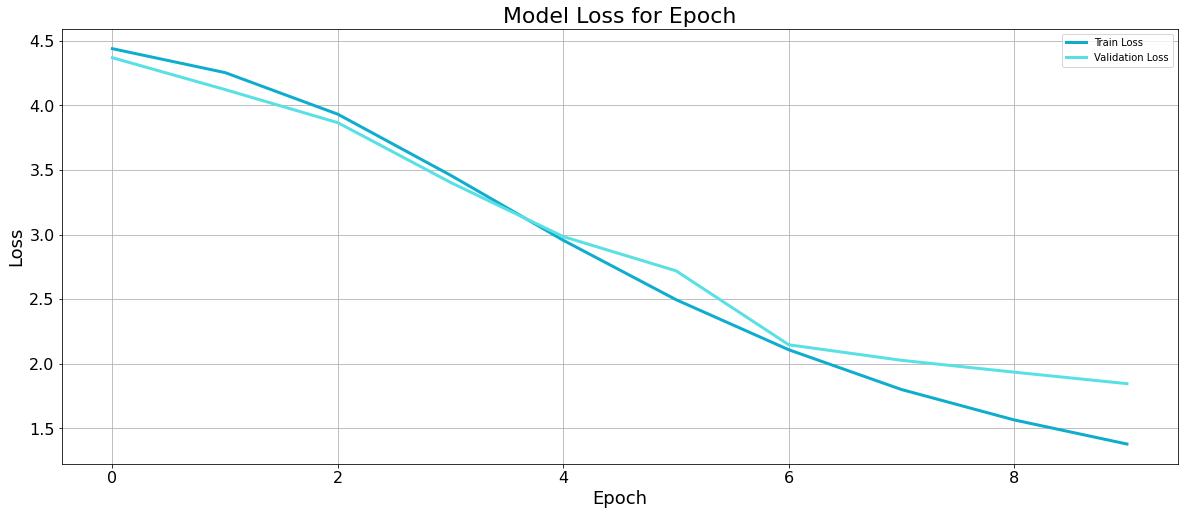

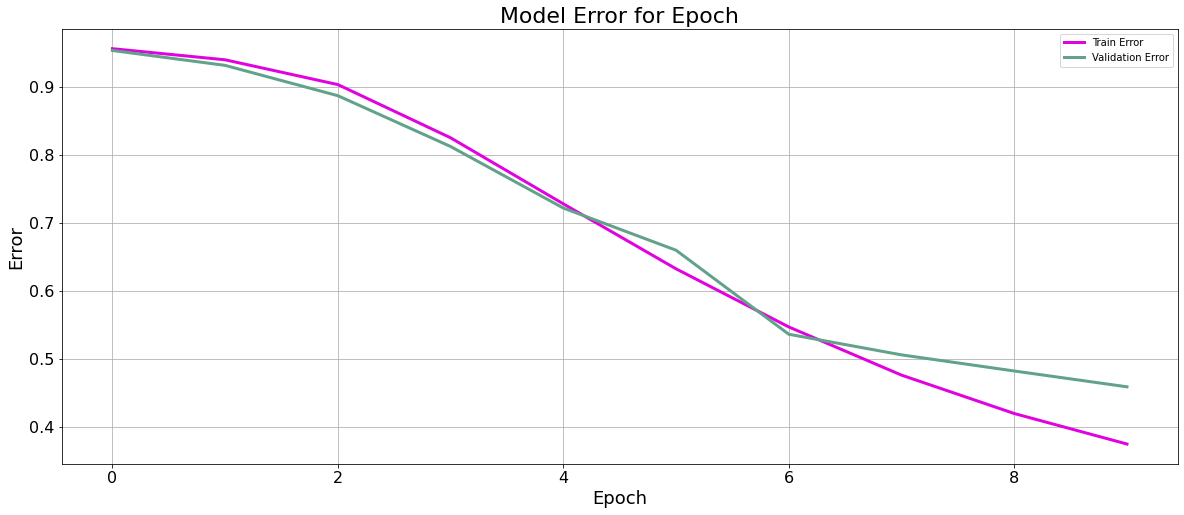

In [24]:
# Plotting the performance of the model in the training and validation phase

plots = [
    (np.arange(0, params["epoch_num"], 1), train_losses, "Train Loss"),
    (np.arange(0, params["epoch_num"], 1), validation_losses, "Validation Loss")
]

show_plot(plots, "Model Loss for Epoch", "Epoch", "Loss")

plots = [
    (np.arange(0, params["epoch_num"], 1), train_acc, "Train Error"),
    (np.arange(0, params["epoch_num"], 1), validation_acc, "Validation Error")
]

show_plot(plots, "Model Error for Epoch", "Epoch", "Error")